# Language Understanding Systems - Mid-Term Project
**FST & GRM Tools for SLU**
---

[University of Trento](http://unitn.it) <br>
[Seyyed Arya Hassanli](https://www.linkedin.com/in/seyyed-arya-hassanli/) - 212168 <br>
[seyyedarya.hassanli@studenti.unitn.it](mailto:seyyedarya.hassanli@studenti.unitn.it)



## Project Definition

This project aims to develop a concept tagger module for NL-SPARQL Dataset in Movie Domain.

## Prerequisites

1. [OpenFST](http://www.openfst.org/twiki/bin/view/FST/WebHome)
2. [OpenGRM](http://www.opengrm.org/twiki/bin/view/GRM/NGramLibrary)

### Install python requirements

First things first, `matplotlib` and `pandas` python libraries are needed for some visualizations. We have to first install these modules.

In [1]:
%%bash
pip3 install matplotlib pandas

### Download Dataset

The dataset used in this project is NL2SparQL4NLU. The dataset will be donwloaded using `git clone`. NL2SparQL4NLU is available on [git repository](https://github.com/esrel/NL2SparQL4NLU).

In [2]:
%%bash
dataset_path="NL2SparQL4NLU"
[ -d $dataset_path ] && echo "Dataset Already Exists." || (git clone https://github.com/esrel/NL2SparQL4NLU.git NL2SparQL4NLU && echo "Dataset Successfuly Cloned.")

Dataset Already Exists.


### Download conll.py

`conll.py` is being used for evaluation. It is modified version of `conlleval` python module and available on the course git repo. Let's download it directly to the working directory.

In [3]:
%%bash
conll_file="conll.py"
[ -f $conll_file ] && echo "conll.py Already Exists." || wget https://raw.githubusercontent.com/esrel/LUS/master/src/conll.py


conll.py Already Exists.


## Data Preparation

NL2SparQL4NLU is the main dataset in this project. It provides sentences in different formats in Movie Domain.
The dataset is split in Train and Test. For both Train and Test subsets Four files are provided:

1. *.conll.txt token-per-line CONLL format with tokens & NLU concept tags; automatically extracted from SPARQL queries & manually inspected.

2. *.features.conll.txt POS-tag and Lemmas in token-per-line CONLL format (with tokens on the first column); produced automatically using TreeTagger.

3. *.utterances.txt utterance only; in utterance-per-line format.

4. *.utterance.labels.txt labels per utterance for intent/utterance classification; automatically extracted from SPARQL queries.



### Reading Corpus

To be able to use the dataset the first step is to read the file and convert it to a usable list format in python. First of all `read_corpus` is defined to read the *utterance-per-line* format. The output would be a list of utterances, and each utterance is a list of tokens.

In [4]:
from typing import NewType, List

Token = NewType('Token', str)
Utter = NewType('Utter', List[Token])

def read_corpus(corpus_path: str) -> List[Utter]:
    """Read an Utterance-per-line corpus file and convert it to list-of-lists format.

    Args:
        corpus_path (str): path to corpus file 

    Returns:
        List[Utter]: corpus as list-of-lists
    """
    f = open(corpus_path, "r")
    utterances = f.readlines()
    return [utterance.split() for utterance in utterances]


In [5]:
trn = 'NL2SparQL4NLU/dataset/NL2SparQL4NLU.train.utterances.txt'
tst = 'NL2SparQL4NLU/dataset/NL2SparQL4NLU.test.utterances.txt'

trn_corpus = read_corpus(trn)
tst_corpus = read_corpus(tst)

print("Print out first 3 utternaces of Train and Test Set...")
print("Train:")
for i in range(0, 3):
    print('\t', ' '.join(trn_corpus[i]))
print("Test:")
for i in range(0, 3):
    print('\t', ' '.join(tst_corpus[i]))

Print out first 3 utternaces of Train and Test Set...
Train:
	 who plays luke on star wars new hope
	 show credits for the godfather
	 who was the main actor in the exorcist
Test:
	 star of thor
	 who is in the movie the campaign
	 list the cast of the movie the campaign


### Corpus Descriptive Statistics

Extract *Corpus* description in terms of:

- total number of words
- total number of utterances

These two functions will help us to have a general view of how big our dataset is.

In [6]:
def corpus_stats(corpus: List[Utter]) -> dict:
    """Caculates the statistics of a corpus

    Args:
        corpus (List[Utter]): List-of-Lists corpus

    Returns:
        dict:  {'tokens': num of tokens
                'utterances': num of utterances}
    """
    stats = {'tokens': 0, 'utterances': 0}
    stats['utterances'] = len(corpus)
    for utterance in corpus:
        stats['tokens'] += len(utterance)
    return stats

Now we can check how many Utterances and Tokens are in the Train and Test set.

In [7]:
import pandas as pd

trn_stats = corpus_stats(trn_corpus)
tst_stats = corpus_stats(tst_corpus)

print("Corpus Stats:")
df = pd.DataFrame([trn_stats, tst_stats], index=['Train', 'Test'])
display(df)


Corpus Stats:


,tokens,utterances
Train,21453,3338
Test,7117,1084


### Generating Lexicon, and CutOff

#### Generate Lexicon
 
>[Lexicon](https://en.wikipedia.org/wiki/Lexicon) is the *vocabulary* of a language. In linguistics, a lexicon is a language's inventory of lexemes.
>
>Linguistic theories generally regard human languages as consisting of two parts: a lexicon, essentially a catalog of a language's words; and a grammar, a system of rules which allow for the combination of those words into meaningful sentences. 
>
>*Lexicon (or Vocabulary) Size* is one of the statistics reported for corpora. While *Word Count* is the number of __tokens__, *Lexicon Size* is the number of __types__ (unique words).

The implemented lexicon generator creates a list of all words used in a corpus.

In [8]:
def generate_lexicon(corpus: List[Utter]) -> List[Token]:
    """Generates Lexicon given a list-of-lists corpus.

    Args:
        corpus (List[Utter]): list-of-list corpus

    Returns:
        List[Token]: Lexicon
    """
    lexicon = []
    for utterance in corpus:
        for token in utterance:
            if token not in lexicon:
                lexicon.append(token)
    lexicon.sort()
    return lexicon


In [9]:
trn_lex = generate_lexicon(trn_corpus)
tst_lex = generate_lexicon(tst_corpus)

print("Size of Lexicons:")
df = pd.DataFrame([len(trn_lex), len(tst_lex)], index=[
                  'Train', 'Test'], columns=['Size'])
display(df)


Size of Lexicons:


,Size
Train,1729
Test,1039


#### Generate Frequency List

To remove the least and/or most used tokens from a corpus and then handling OOV words, there should be a function to calculate the frequency of words in a corpus. The Frequency List is generated by simply counting the occurrences of each word in the corpus. The provided function will generate a dictionary in which each key is a word and the corresponding value is number of occurrences of it. Then another function is used to select the top n items out of a `dict`.

In [10]:
def generate_freq_list(corpus: List[Utter], case_sensitive: bool = True) -> dict:
    """Generates Frequency List of words. Frequency fo each word is number of occurrences in corpus.

    Args:
        corpus (List[Utter]): list-of-list corpus
        case_sensitive (bool, optional): Defaults to True.

    Returns:
        dict: in format of: {'word_1': freq_1, 'word_2': freq_2, ...}
    """
    freq = {}
    for utterance in corpus:
        for token in utterance:
            if not case_sensitive:
                token = token.lower()
            if token in freq:
                freq[token] += 1
            else:
                freq[token] = 1
    return dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))


def nbest(freq_list: dict, n: int = 1) -> dict:
    """Retrives n best items of a dict based on their Value; The higher the better.

    Args:
        freq_list (dict): frequency list in format of: {'word_1': freq_1, 'word_2': freq_2, ...}
        n (int, optional): Number of items to return from top of the sorted list. Defaults to 1.

    Returns:
        dict: a sorted dict of size n. {'top_word_1': max_freq_1, 'top_word_2': max_freq_2, ...}
    """
    return dict(sorted(freq_list.items(), key=lambda item: item[1], reverse=True)[:n])


Top 5 words in
Train set:


,word,count
1,the,1337
2,movies,1126
3,of,607
4,in,582
5,movie,564


Test set:


,word,count
1,the,406
2,movies,367
3,movie,200
4,of,194
5,in,184


[]

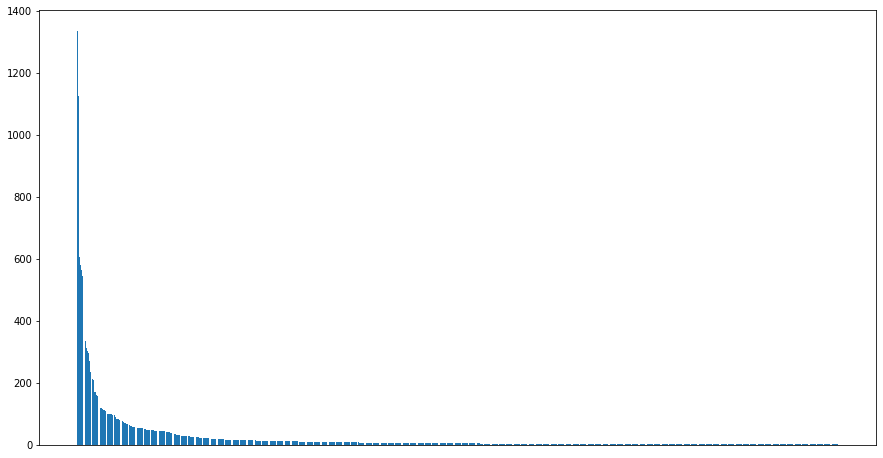

In [11]:
import matplotlib.pyplot as plt

trn_freq_list = generate_freq_list(trn_corpus)
tst_freq_list = generate_freq_list(tst_corpus)

trn_freq_top_5 = nbest(trn_freq_list, 5)
tst_freq_top_5 = nbest(tst_freq_list, 5)

print("Top 5 words in")

print("Train set:")
df = pd.DataFrame(trn_freq_top_5.items(), columns=['word', 'count'])
df.index += 1
display(df)

print("Test set:")
df = pd.DataFrame(tst_freq_top_5.items(), columns=['word', 'count'])
df.index += 1
display(df)

plt.figure(figsize=(15, 8))
D = nbest(trn_freq_list,int(len(trn_freq_list)/2))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.plot()

#### Cut-off Lexicon

Given a Frequency List it is possible to remove the words that are occured more than or less than a specific value. This will lead to Out of Vocabulary tokens.

In [12]:
import math


def cutoff_freq_list(freq_list: dict, min_cut: int = 0, max_cut: int = math.inf) -> List[Token]:
    """Computes a lexicon in which all words met the frequency threshold. All words of the output lexicon are occured at
    least `min_cut` times and at most `max_cut` times in the `freq_list`.

    Args:
        freq_list (dict): frequency list generated by generate_freq_list
        min_cut (int, optional): minimum threshold of counts. Defaults to 0.
        max_cut (int, optional): maximum threshold of counts. Defaults to math.inf.

    Returns:
        List[Token]: A Lexicon with the given conditions.
    """
    lexicon = []
    for word, freq in freq_list.items():
        if freq < min_cut or freq > max_cut:
            continue
        lexicon.append(word)
    lexicon.sort()
    return lexicon


Check lexicon size by applying different cutoff conditions:

1. No cutoff
2. cutoff with min=2
3. cutoff with max=100
4. cutoff with both min=2 and max=100  

In [13]:
cut_lex_stats = []
for min_cut in [0,2]:
    for max_cut in [math.inf,100]:
        cut_lex_stats.append({
            'min': min_cut,
            'max': max_cut,
            'size': len(cutoff_freq_list(trn_freq_list,min_cut=min_cut,max_cut=max_cut))
        })

df = pd.DataFrame(cut_lex_stats)
df.index += 1
print("Lexicon size by applying different cutoff conditions:")
display(df)

Lexicon size by applying different cutoff conditions:


,min,max,size
1,0,inf,1729
2,0,100.0,1694
3,2,inf,950
4,2,100.0,915


### Manage OOV and Tags


#### Add Tags

Having sentence begin and sentence end tags leads to a better model.
>The beginning of the sentence tag gives the bigram context of the first word; and encodes probability of a word to start a sentence. Adding the end of the sentence tag, on the other hand, makes the bigram model a true probability distribution (Jurafsky and Martin). "Without it, the sentence probabilities for all sentences of a given length would sum to one. This model would define an infinite set of probability distributions, with one distribution per sentence length."

Therefore, a function is implemented to add a `begin_tag` token at the beginning of each utterance and an `end_tag` to the end of it.

In [14]:
def add_tags(corpus: List[Utter], begin_tag: str = '<s>', end_tag: str = '</s>') -> List[Utter]:
    """Add Begin and End tags to each utternace in a corpus.

    Args:
        corpus (List[Utter]): a list-of-list corpus format.
        begin_tag (str, optional): Begin of Sentence Tag. Defaults to '<s>'.
        end_tag (str, optional): End of Sentence Tag. Defaults to '</s>'.

    Returns:
        List[Utter]: New Corpus
    """
    tmp_corpus = []
    for utternace in corpus:
        tmp_corpus.append([begin_tag] + utternace + [end_tag])
    return tmp_corpus


Add tags to train and test corpuses:

In [15]:
trn_tg_corpus = add_tags(trn_corpus,begin_tag='<s>',end_tag='</s>')
tst_tg_corpus = add_tags(tst_corpus,begin_tag='<s>',end_tag='</s>')
print("Print out first utterance of both Train and Test set.")
print("Train:")
print('\t',' '.join(trn_tg_corpus[0]))
print("Test:")
print('\t',' '.join(tst_tg_corpus[0]))


Print out first utterance of both Train and Test set.
Train:
	 <s> who plays luke on star wars new hope </s>
Test:
	 <s> star of thor </s>


#### Handle OOV

When working on test data, there are tokens that are not seen before in lexicon. They can either be removed from lexicon because of the sparsity of data or not seen in train data at all. We have to change these tokens to a single tag allocated for Unseen Words. A function will replace every tokens of a corpus that are not available in a given lexicon with a specific `unk` tag.

In [16]:
def replace_oov(corpus: List[Utter], lexicon: List[Token], unk:str='<unk>') -> List[Utter]:
    """Replace Out of Vocabulary words in Corpus with `unk`. The vocabulary is given as a Lexicon. 

    Args:
        corpus (List[Utter]): a list-of-list format corpus
        lexicon (List[Token]): Vocabulary
        unk (str, optional): The token to use as unknown word. Defaults to '<unk>'.

    Returns:
        List[Utter]: The New Corpus with replaced OOVs.
    """
    return [[token if token in lexicon else unk for token in sent] for sent in corpus]

Let's do the whole corpus preparation pipeline and see some stats. The pipeline consists of reading corpus from file, applying frequency cutoff, replacing OOV, and adding sentence tags.

In [17]:
trn_corpus = read_corpus(trn)
trn_freq_list_m = generate_freq_list(trn_corpus)
trn_lex_m = cutoff_freq_list(trn_freq_list_m, min_cut=2)
trn_corpus_m = replace_oov(trn_corpus, trn_lex_m, unk='<unk>')
trn_corpus_m = add_tags(trn_corpus_m)

print("One utterance of the Modified(CutOff, OOV, Tag) corpus:")
print(' '.join(trn_corpus_m[222]))

tst_corpus = read_corpus(tst)
tst_freq_list_m = generate_freq_list(tst_corpus)
tst_lex_m = cutoff_freq_list(tst_freq_list_m, min_cut=2)
tst_corpus_m = replace_oov(tst_corpus, tst_lex_m, unk='<unk>')
tst_corpus_m = add_tags(tst_corpus_m)


print("\nSome stats for the Modified corpus:")
trn_stats_m = corpus_stats(trn_corpus_m)
tst_stats_m = corpus_stats(tst_corpus_m)

df = pd.DataFrame([trn_stats_m, tst_stats_m], index=['Train', 'Test'])
display(df)


One utterance of the Modified(CutOff, OOV, Tag) corpus:
<s> find out the budget of <unk> </s>

Some stats for the Modified corpus:


,tokens,utterances
Train,28129,3338
Test,9285,1084


### Conll Corpus Format

Corpus in CoNLL format consists of series of sentences, separated by blank lines. Each sentence is encoded using a table (or "grid") of values, where each line corresponds to a single word, and each column corresponds to an annotation type. In our dataset there is one column giving information about the concept of each token in IOB scheme. IOB is useful to represent concept of multi-word spans. Each tag has two parts; A Prefix and a Concept. 

Prefixes are:
- __B__ for (__B__)eginning of span
- __I__ for (__I__)nside of span
- __O__ for (__O__)tside of span (no prefix or suffix, just `O`)


#### Read CONLL corpus file

A function is implemented to read a CoNLL file into a list of utterances format. Each utterance is list of IOB Tokens. An IOB token is a tuple with the token as it's first element and IOB tag as it's second one.

In [18]:
from typing import Tuple

IOBToken = NewType('IOBToken', Tuple)
IOBUtter = NewType('IOBUtter', List[IOBToken])


def read_corpus_conll(corpus_file: str, fs: str = "\t") -> List[IOBUtter]:
    """Read Corpus in CoNLL Format.

    Args:
        corpus_file (str): corpus file path in conll format
        fs (str, optional): field separator. Defaults to "\t".

    Raises:
        ValueError: Unexpected number of columns

    Returns:
        List[IOBUtter]: Corpus as list of IOB Utterances.
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError(
                    "Unexpected number of columns {} ({})".format(len(feats), featn))
            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents

Reading Train and Test CoNLL corpuses

In [19]:
trn_conll = 'NL2SparQL4NLU/dataset/NL2SparQL4NLU.train.conll.txt'
tst_conll = 'NL2SparQL4NLU/dataset/NL2SparQL4NLU.test.conll.txt'

trn_conll_corpus = read_corpus_conll(trn_conll)
tst_conll_corpus = read_corpus_conll(tst_conll)

print('One Utterance in CoNLL Corpus Format:\n')
print(trn_conll_corpus[0])

One Utterance in CoNLL Corpus Format:

[('who', 'O'), ('plays', 'O'), ('luke', 'B-character.name'), ('on', 'O'), ('star', 'B-movie.name'), ('wars', 'I-movie.name'), ('new', 'I-movie.name'), ('hope', 'I-movie.name')]


#### Handle Concepts

1. Get All Concepts
2. Get Concepts' frequency list


In [20]:
import re


def parse_iob(label: str) -> Tuple:
    """Parse an output label to extract IOB tag

    Args:
        label (str): IOB Label format e.g. I-actor.name 

    Returns:
        Tuple: (IOB, Concept)
    """
    m = re.match(r'^([^-]*)-(.*)$', label)
    return m.groups() if m else (label, None)


def get_chunks(corpus: List[IOBUtter], otag: str = "O") -> set:
    """Get List of all available Concepts in coprus

    Args:
        corpus (List[IOBUtter]): CoNLL Corpus
        otag (str, optional): O tag. Defaults to "O".

    Returns:
        set: Alphabeticaly ordered concepts.
    """
    sents = corpus
    return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])


def get_chunks_freq(corpus: List[IOBUtter]) -> dict:
    """Get Dictionary of concepts and their number of occurance.

    Args:
        corpus (List[IOBUtter]): CoNLL Corpus

    Returns:
        dict: {'concept_1': 'count_1', 'concept_2': 'count_2', ...}
    """
    chunks = get_chunks(corpus)
    chunk_freq = {chunk: 0 for chunk in chunks}
    for sent in corpus:
        for token in sent:
            chunk = parse_iob(token[-1])[1]
            if chunk is None:
                continue
            if chunk in chunk_freq:
                chunk_freq[chunk] += 1
    return chunk_freq


Let's see some simple statistics.

Number of concepts:


,Num of Concepts
Train,23
Test,22


Most Frequent concepts in Train Set:


,Concept,Count
1,movie.name,3157
2,director.name,455
3,actor.name,437
4,producer.name,336
5,person.name,280
6,movie.subject,247
7,rating.name,240
8,country.name,212
9,movie.language,207
10,movie.release_date,201


[]

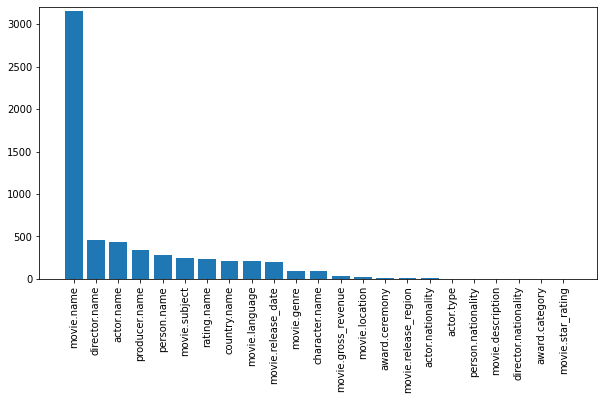

In [21]:
import matplotlib.pyplot as plt

trn_chunks = get_chunks(trn_conll_corpus)
tst_chunks = get_chunks(tst_conll_corpus)

trn_chunk_freqs = get_chunks_freq(trn_conll_corpus)
tst_chunk_freqs = get_chunks_freq(tst_conll_corpus)

print("Number of concepts:")
df = pd.DataFrame([len(trn_chunks),len(tst_chunks)],index=['Train','Test'],columns=['Num of Concepts'])
display(df)

print("Most Frequent concepts in Train Set:")
df = pd.DataFrame(nbest(trn_chunk_freqs,len(trn_chunk_freqs)).items(),columns=['Concept','Count'])
df.index += 1
display(df)

plt.figure(figsize=(10, 5))
D = nbest(trn_chunk_freqs,len(trn_chunk_freqs))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)),  list(D.keys()),rotation='vertical')
plt.ylim([0, 3200])
plt.plot()

#### Labels

1. get all labels
2. get labels' frequency list

In [22]:
def get_labels(corpus: List[IOBUtter]) -> dict:
    """Get Dictionary of all Labels in CoNLL Corpus

    Args:
        corpus (List[IOBUtter]): CoNLL Corpus

    Returns:
        dict: All Labels
    """
    labels = {}
    return {token[1] for sent in corpus for token in sent}

def get_labels_freq(corpus: List[IOBUtter]) -> dict:
    """Get Frequency list of labels in CoNLL Corpus

    Args:
        corpus (List[IOBUtter]): CoNLL Corpus

    Returns:
        dict: {'label_1': 'count_1', 'label_2': 'count_2', ...}
    """
    labels_freq = {label: 0 for label in get_labels(corpus)}
    for sent in corpus:
        for token in sent:
            labels_freq[token[1]] += 1
    return labels_freq
    

Let's see some simple statistics.

Number of Labels:


,Num of Labels
Train,41
Test,39


Most Frequent Labels in Train Set:


,Label,Count
1,O,15391
2,I-movie.name,1755
3,B-movie.name,1402
4,B-director.name,237
5,B-actor.name,227


[]

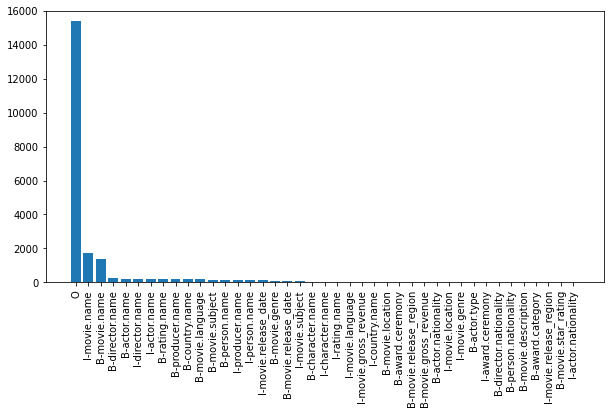

In [23]:
trn_labels = get_labels(trn_conll_corpus)
tst_labels = get_labels(tst_conll_corpus)

trn_label_freqs = get_labels_freq(trn_conll_corpus)
tst_label_freqs = get_labels_freq(tst_conll_corpus)

print("Number of Labels:")
df = pd.DataFrame([len(trn_labels), len(tst_labels)], index=[
                  'Train', 'Test'], columns=['Num of Labels'])
display(df)

print("Most Frequent Labels in Train Set:")
df = pd.DataFrame(nbest(trn_label_freqs, 5).items(),
                  columns=['Label', 'Count'])
df.index += 1
display(df)

plt.figure(figsize=(10, 5))
D = nbest(trn_label_freqs,len(trn_label_freqs))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)),  list(D.keys()),rotation='vertical')
plt.ylim([0, 16000])
plt.plot()

#### More Detailed Statistics of Concepts and Labels

1. Min, Max, and Average of Each Concept Length
2. Average number of concepts per utternace

In [24]:
from statistics import mean


def get_chunks_lens(corpus: List[IOBUtter], otag: str = 'O') -> dict:
    """Get Min, Max, and Average of each concept length

    Args:
        corpus (List[IOBUtter]): CoNLL Corpus
        otag (str, optional): O Tag. Defaults to 'O'.

    Returns:
        dict: {'entity_1': {'min': minimum_len, 'max': maximum_len, 'avg': average_len}, ...}
    """
    entities_len = {entity: [] for entity in get_chunks(corpus)}
    entities_len['*'] = []
    entities_per_sentence = []

    for sent in corpus:
        last_entity = None
        last_entity_len = 0
        entities_in_sent = 0

        for token in sent:
            tag = token[-1]
            if tag == otag:
                continue
            iob = parse_iob(tag)
            if iob[0] == 'B':
                entities_in_sent += 1
                if last_entity:
                    entities_len[last_entity].append(last_entity_len)
                    entities_len['*'].append(last_entity_len)
                last_entity = iob[1]
                last_entity_len = 1
            elif iob[0] == 'I':
                last_entity_len += 1

        if last_entity:
            entities_len[last_entity].append(last_entity_len)
            entities_len['*'].append(last_entity_len)

    entities_len = {entity: {'min': min(entity_len), 'max': max(entity_len), 'avg': mean(
        entity_len)} for entity, entity_len in entities_len.items()}

    return entities_len


def get_entities_per_sent(corpus: List[IOBUtter], otag: str = 'O') -> dict:
    """Returns Min, Max, and Average number of entities per utternace

    Args:
        corpus (List[IOBUtter]): CoNLL Corpus
        otag (str, optional): O Tag. Defaults to 'O'.

    Returns:
        dict: {'min': minimum_number, 'max': maximum_number, 'avg': average_number}
    """
    entities_per_sent = []
    for sent in corpus:
        entities_in_sent = 0
        for token in sent:
            tag = token[-1]
            if tag == otag:
                continue
            iob = parse_iob(tag)
            if iob[0] == 'B':
                entities_in_sent += 1
        entities_per_sent.append(entities_in_sent)
    return {'min': min(entities_per_sent), 'max': max(entities_per_sent), 'avg': mean(entities_per_sent)}


In [25]:
trn_chunks_lens = get_chunks_lens(trn_conll_corpus)
tst_chunks_lens = get_chunks_lens(tst_conll_corpus)

trn_entities_per_sent = get_entities_per_sent(trn_conll_corpus)
tst_entities_per_sent = get_entities_per_sent(tst_conll_corpus)

print("Each Utterance in Train Set has at least {} entities, at most {} entities and on average {} entities.\n".format(
    trn_entities_per_sent['min'], trn_entities_per_sent['max'], trn_entities_per_sent['avg']))
print("Length of Concepts in Train Set:")
df = pd.DataFrame([value for key, value in trn_chunks_lens.items()], index=[
                  key for key, value in trn_chunks_lens.items()])
display(df)

Each Utterance in Train Set has at least 0 entities, at most 4 entities and on average 0.9700419412822049 entities.

Length of Concepts in Train Set:


,min,max,avg
movie.genre,1,2,1.042553
movie.location,1,2,1.235294
actor.type,1,1,1.000000
character.name,1,8,1.897959
award.category,1,1,1.000000
movie.gross_revenue,3,6,4.250000
movie.subject,1,6,1.430233
movie.star_rating,1,1,1.000000
person.nationality,1,1,1.000000
director.name,1,3,1.919831


## Concept Tagging

One common task in Natural Language Understanding is entity extraction or concept tagging. In this task, each sentence should be divided into segments of tokens; Then each segment should be tagged by a label (concept).

In this project the first goal is to create a concept tagging pipeline using Hidden Markov Models. 

### The Pipeline

A common pipeline of a concept tagger is consist of three main components:


|                   | Description                      
|:------------------|:------------------------------
| $$\lambda_{W}$$   | FSA representation of an input sentence
| $$\lambda_{W2T}$$ | FST to translate words into output labels (e.g. `iob+type`)
| $$\lambda_{*LM}$$ | FSA Ngram Language Model to score the sequences of output labels

Consequently, Sequence Labeling ($\lambda$) is performed by composition of these three components as:

$$\lambda = \lambda_{W} \circ \lambda_{W2T} \circ \lambda_{*LM}$$


### Initialize Workspace

To begin with there are some requirements:

1. import necessary python libraries
2. import conll evaluator
3. assign dataset files to root folder to have easier access

In [26]:
# import necessary Libraries
import os
import sys
import subprocess
import matplotlib.pyplot as plt

# import evaluator
from conll import evaluate

In [27]:
%%bash

dpath='NL2SparQL4NLU/dataset/NL2SparQL4NLU'

cp $dpath.train.utterances.txt trn.txt
cp $dpath.test.utterances.txt tst.txt

cp $dpath.train.conll.txt trn.conll
cp $dpath.test.conll.txt tst.conll

In [28]:
trn = 'trn.txt'
tst = 'tst.txt'

trn_conll = 'trn.conll'
tst_conll = 'tst.conll'

### Create Symbol Tables

first we have to create our symbol tables. Our input symbols are tokens available in corpus, and output symbols are CoNLL labels. We will create multiple input symbol tables with different cut-off frequencies. The minimum cutoff varies between 1 and 6.

In [29]:
%%bash
sym_path="syms"
[ -d $sym_path ] && echo "$sym_path is already exists" || mkdir $sym_path

In [30]:
sym_path = "syms"

trn_corpus = read_corpus(trn)

cutoff_mins = [2, 3, 4, 5, 6]
for min_cut in cutoff_mins:
    trn_freq_list = generate_freq_list(trn_corpus)
    trn_lex = cutoff_freq_list(trn_freq_list, min_cut=min_cut)
    trn_lex.append('<s>')
    trn_lex.append('</s>')
    
    input_file = os.path.join(sym_path, "isyms_(mincut_"+str(min_cut)+").trn.txt")
    output_file =  os.path.join(sym_path, "isyms_(mincut_"+str(min_cut)+").txt")
    
    with open(input_file, 'w') as f:
        f.write("\n".join(trn_lex) + "\n")

In [31]:
%%bash
sym_path="syms"
for i in {2..6}
do 
    ngramsymbols --OOV_symbol='<unk>' "$sym_path/isyms_(mincut_$i).trn.txt" "$sym_path/isyms_(mincut_$i).txt"
done

echo "list of isym files in $sym_path:"
ls $sym_path | grep "isyms_(mincut_[0-9+]).txt"

list of isym files in syms:
isyms_(mincut_2).txt
isyms_(mincut_3).txt
isyms_(mincut_4).txt
isyms_(mincut_5).txt
isyms_(mincut_6).txt


Now, it's time for creating output symbols which are simply our labels that are observed in training set. Then as we did for input table, we apply different cutoff thresholds.

In [32]:
# Let's define a function to simplify working with data
# get column from loaded corpus (tokens are tuples)
def get_column(corpus, column=-1):
    return [[word[column] for word in sent] for sent in corpus]

trn_conll_corpus = read_corpus_conll(trn_conll)

trn_t = get_column(trn_conll_corpus, column=-1)
trn_t_freq_list = generate_freq_list(trn_t)

for min_cut in cutoff_mins:
    trn_t_lex = cutoff_freq_list(trn_t_freq_list,min_cut=min_cut)
    with open(os.path.join(sym_path,'osyms_(mincut_{}).trn.t.txt'.format(min_cut)), 'w') as f:
        f.write("\n".join(trn_t_lex) + "\n")

In [33]:
%%bash
sym_path="syms"
for i in {2..6}
do 
    ngramsymbols --OOV_symbol='<unk>' "$sym_path/osyms_(mincut_$i).trn.t.txt" "$sym_path/osyms_(mincut_$i).t.txt"
done

echo "list of osym files in $sym_path:"
ls $sym_path | grep "osyms_(mincut_[0-9+]).t.txt"

list of osym files in syms:
osyms_(mincut_2).t.txt
osyms_(mincut_3).t.txt
osyms_(mincut_4).t.txt
osyms_(mincut_5).t.txt
osyms_(mincut_6).t.txt


### Compile input and output into FAR

In [34]:
%%bash
sym_path="syms"
far_path="far"

[ -d $far_path ] && echo "$far_path is already exists" || mkdir $far_path

# compile Train and Test set with all input symbol tables

for i in {2..6}
do 
    farcompilestrings \
        --symbols="$sym_path/isyms_(mincut_$i).txt" \
        --keep_symbols \
        --unknown_symbol='<unk>' \
        trn.txt "$far_path/trn_(mincut_$i).far"

    farcompilestrings \
        --symbols="$sym_path/isyms_(mincut_$i).txt"  \
        --keep_symbols \
        --unknown_symbol='<unk>' \
        tst.txt "$far_path/tst_(mincut_$i).far" 
done

echo "list of far files created in $far_path:"
ls $far_path | grep "[trn|tst]_(mincut_[0-9+]).far"

list of far files created in far:
trn_(mincut_2).far
trn_(mincut_3).far
trn_(mincut_4).far
trn_(mincut_5).far
trn_(mincut_6).far
tst_(mincut_2).far
tst_(mincut_3).far
tst_(mincut_4).far
tst_(mincut_5).far
tst_(mincut_6).far


Now, to compile output tags to far we need to write them in corpus format in a file. Then we can compile it to a FAR.

In [35]:
with open('trn.t.txt', 'w') as f:
    for s in trn_t:
        f.write(" ".join(s) + "\n")

In [36]:
%%bash
sym_path="syms"
far_path="far"

# compile Output tags with all output symbol tables
for i in {2..6}
do 
    farcompilestrings \
        --symbols="$sym_path/osyms_(mincut_$i).t.txt" \
        --keep_symbols \
        --unknown_symbol='<unk>' \
        trn.t.txt "$far_path/trn_(mincut_$i).t.far"
done

echo "list of far files created in $far_path:"
ls $far_path | grep "trn_(mincut_[0-6]).t.far"



list of far files created in far:
trn_(mincut_2).t.far
trn_(mincut_3).t.far
trn_(mincut_4).t.far
trn_(mincut_5).t.far
trn_(mincut_6).t.far


Until now we have created the first part of our pipeline which is $\lambda_{W}$.

### Train $\lambda_{*LM}$

$\lambda_{*LM}$ is language model (Ngram) to score the pipeline. A Ngram model will be used as the last part of the pipeline. To assess the different parameters for our pipeline, here two parameters will be considered:

1. Ngram order
2. Ngram Smoothing

As for order, ngram orders from 1 to 5 will be tested and for smoothing, all available smoothing method in `ngrammake` are going to be used. Mentioned in their documentation these smoothing methods are available:

* absolute
* katz
* kneser_ney 
* presmoothed
* unsmoothed
* katz_frac
* witten_bell

During the test, there was an unknown error with katz_frac method. Therefore, this method is ignored.

In [37]:
%%bash

far_path='far'
ngram_path='ngram'
lm_path='lm'

[ -d $ngram_path ] && echo "$ngram_path already exists" || mkdir $ngram_path
[ -d $lm_path ] && echo "$lm_path already exists" || mkdir $lm_path

for min_cut in {2..6}
do
    for order in {1..6}
    do
        ngramcount --order=$order \
            "$far_path/trn_(mincut_$min_cut).t.far" \
            "$ngram_path/trn_(mincut_$min_cut)_(order_$order).t.cnt"
  
        for method in "absolute" "katz" "kneser_ney" "presmoothed" "unsmoothed" "witten_bell"
        do
            ngrammake --method=$method \
                "$ngram_path/trn_(mincut_$min_cut)_(order_$order).t.cnt" \
                "$lm_path/t_(mincut_$min_cut)_(order_$order)_($method).lm"
        done
    done
done

echo "LM models created."

LM models created.


### MLE Estimator

As we want to do the concept tagging task using HMM we have to create a MLE pipeline to take the observations into account. For the bigram case the pipeline would be:

$$\lambda = \lambda_{W} \circ \lambda_{W2T_{MLE}} \circ \lambda_{LM_{2}}$$

The $\lambda_{LM_{2}}$ provides the transition probabilities and the $\lambda_{W2T_{MLE}}$ which we are going to implement provides emission probabilities.

To have a **Baseline** this configuration set is selected:
* Input CutOff: 2
* Output CutOff: 2
* Ngram Size: 1
* Ngram Smoothing: No Smoothing

In [38]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

[ -d $w2tmle_path ] && echo "$w2tmle_path already exists" || mkdir $w2tmle_path

icut=2
ocut=2
order=1
smoothing='unsmoothed'

cat "$sym_path/isyms_(mincut_$icut).txt" "$sym_path/osyms_(mincut_$ocut).t.txt" | cut -f 1 | sort | uniq > "$sym_path/msyms.m.lst.txt"

ngramsymbols --OOV_symbol='<unk>' "$sym_path/msyms.m.lst.txt" "$sym_path/msyms.t.txt"

# let's convert data to ngrams
cat trn.conll | sed '/^$/d' | awk '{print $2,$1}' > $w2tmle_path/trn.w2t.txt

# compile to far
farcompilestrings \
    --symbols=$sym_path/msyms.t.txt \
    --keep_symbols \
    --unknown_symbol='<unk>' \
    $w2tmle_path/trn.w2t.txt $w2tmle_path/trn.w2t.far
    
# count bigrams
ngramcount --order=2 $w2tmle_path/trn.w2t.far $w2tmle_path/trn.w2t.cnt
# make a model
ngrammake $w2tmle_path/trn.w2t.cnt $w2tmle_path/trn.w2t.lm

# print ngram probabilities as negative logs
ngramprint \
    --symbols=$sym_path/msyms.t.txt\
    --negativelogs \
    $w2tmle_path/trn.w2t.lm $w2tmle_path/trn.w2t.probs

Now we have to convert probabilities into a FST.

In [39]:
def make_w2t_mle(probs, out='w2t_mle.tmp'):
    special = {'<epsilon>', '<s>', '</s>'}
    oov = '<unk>'  # unknown symbol
    state = '0'    # wfst specification state
    fs = " "       # wfst specification column separator
    otag = 'O'
    mcn = 3        # minimum column number
    
    lines = [line.strip().split("\t") for line in open(probs, 'r')]

    with open(out, 'w') as f:
        for line in lines:
            ngram = line[0]
            ngram_words = ngram.split()  # by space
            if len(ngram_words) == 2:
                if set(ngram_words).isdisjoint(set(special)):
                    if ngram_words[0] in [otag, oov]:
                        f.write(fs.join([state, state] + ngram_words + [line[1]]) + "\n")
                    elif ngram_words[0].startswith("B-") or ngram_words[0].startswith("I-"):
                        f.write(fs.join([state, state] + line) + "\n")
        f.write(state + "\n")

In [40]:
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

make_w2t_mle(os.path.join(w2tmle_path,'trn.w2t.probs'), out=os.path.join(w2tmle_path,'trn.w2t_mle.txt'))

In [41]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

icut=2
ocut=2
order=1
smoothing='unsmoothed'

fstcompile \
    --isymbols="$sym_path/osyms_(mincut_$ocut).t.txt" \
    --osymbols="$sym_path/isyms_(mincut_$icut).txt" \
    --keep_isymbols \
    --keep_osymbols \
    $w2tmle_path/trn.w2t_mle.txt $w2tmle_path/w2t_mle.bin
    
# we need to invert it to have words on input
fstinvert $w2tmle_path/w2t_mle.bin $w2tmle_path/w2t_mle.inv.bin

fstinfo $w2tmle_path/w2t_mle.inv.bin | head -n 8

fst type                                          vector
arc type                                          standard
input symbol table                                syms/isyms_(mincut_2).txt
output symbol table                               syms/osyms_(mincut_2).t.txt
# of states                                       1
# of arcs                                         1513
initial state                                     0
# of final states                                 1


Now Let's test one sample sentence. We have to first extract the Test FAR into a folder and copy one sample of it.

In [42]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

icut=2
ocut=2
order=1
smoothing='unsmoothed'

wdir='wdir'
mkdir -p $wdir

farextract --filename_prefix="$wdir/" "$far_path/tst_(mincut_$icut).far"

cp "$wdir/tst.txt-0001" sent.fsa

fstprint --isymbols="$sym_path/isyms_(mincut_$icut).txt" sent.fsa 

0	1	star	star
1	2	of	of
2	3	<unk>	<unk>
3


In [43]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

icut=2
ocut=2
order=1
smoothing='unsmoothed'

fstcompose sent.fsa $w2tmle_path/w2t_mle.inv.bin | fstcompose - "$lm_path/t_(mincut_$ocut)_(order_$order)_($smoothing).lm" | fstshortestpath | fstrmepsilon | fsttopsort | fstprint

0	1	star	B-movie.name	6.09388542
1	2	of	O	3.86926198
2	3	<unk>	O	4.46324492
3	2.00510979


### Evaluate Baseline

The Baseline to be tested has the following settings as mentioned before:

* Input CutOff: 2
* Output CutOff: 2
* Ngram Size: 1
* Ngram Smoothing: No Smoothing

First we evaluate a Pipeline with this settings and then we will assess the other configurations to select the best one.
For this Evaluation the `tst.conll` will be used as Test set. We have already implemented a function to read the `.conll` file. However, another function is needed to  convert our FST output to python usable corpus. Therefore, `read_fst4conll` provided in lab sessions is used.
To compare the FST output and tst file, the `evaluate` method of provided `conll` library is used.

In [44]:
%%bash

wdir='wdir'
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

icut=2
ocut=2
order=1
smoothing='unsmoothed'


farr=($(ls $wdir))

for f in ${farr[@]}
do
    fstcompose $wdir/$f $w2tmle_path/w2t_mle.inv.bin | \
    fstcompose - "$lm_path/t_(mincut_$ocut)_(order_$order)_($smoothing).lm" | \
        fstshortestpath | fstrmepsilon | fsttopsort | fstprint --isymbols="$sym_path/isyms_(mincut_$icut).txt" 
done > $w2tmle_path/w2t_mle.inv.out

In [45]:
def read_fst4conll(fst_file, fs="\t", oov='<unk>', otag='O', sep='+', split=False):
    """
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :param oov: token to map to otag (we need to get rid of <unk> in labels)
    :param otag: otag symbol
    :param sep: 
    :param split:
    :return: corpus 
    """
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(fst_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            # arc has minimum 3 columns, else final state
            if len(feats) >= 3:
                ist = feats[2]  # 3rd column (input)
                ost = feats[3]  # 4th column (output)
                # replace '<unk>' with 'O'
                ost = otag if ost == oov else ost
                # ignore for now
                ost = ost.split(sep)[1] if split and ost != otag else ost
                
                words.append((ist, ost))
            else:
                sents.append(words)
                words = []
        else:
            if len(words) > 0:
                sents.append(words) 
                words = []
    return sents

In [52]:
refs = read_corpus_conll(tst_conll)
hyps = read_fst4conll(os.path.join(w2tmle_path,'w2t_mle.inv.out'))

results = evaluate(refs, hyps)

pd_tbl = pd.DataFrame().from_dict(results, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
movie.genre,0.931,0.750,0.831,36
movie.location,0.000,0.000,0.000,7
actor.type,1.000,1.000,1.000,2
character.name,0.625,0.333,0.435,15
award.category,1.000,0.000,0.000,2
movie.gross_revenue,0.000,0.000,0.000,5
movie.subject,0.641,0.568,0.602,44
movie.star_rating,1.000,0.000,0.000,1
movie.type,1.000,0.000,0.000,4
director.name,0.543,0.617,0.578,81


The evaluated Baseline has a $F_1$ of **0.561**, $Precision$ of **0.549** and $Recall$ of **0.573**.
In the next chapter we will try to improve the $F_1$ by Tuning the Parameters.

### Parameter Tuning

In total we have 4 parameters to evaluate.

1. Ngram size
2. Input CutOff Frequency
3. Output CutOff Frequency
4. Ngram Smoothing method

As there are too many combinations for these parameters, and the process will take much time, we can tune the parameters one by one.

#### Ngram Size

The first parameter to tune is Ngram size for $\lambda_{LM}$. We will try Ngram orders of 1 to 6.

In [53]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

[ -d $w2tmle_path ] && echo "$w2tmle_path already exists" || mkdir $w2tmle_path

icut=2
ocut=2
smoothing='unsmoothed'

for order in {1..6}
do
    cat "$sym_path/isyms_(mincut_$icut).txt" "$sym_path/osyms_(mincut_$ocut).t.txt" | cut -f 1 | sort | uniq > "$sym_path/msyms.m.lst.txt"

    ngramsymbols --OOV_symbol='<unk>' "$sym_path/msyms.m.lst.txt" "$sym_path/msyms.t.txt"

    # let's convert data to ngrams
    cat trn.conll | sed '/^$/d' | awk '{print $2,$1}' > "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.txt"

    # compile to far
    farcompilestrings \
        --symbols=$sym_path/msyms.t.txt \
        --keep_symbols \
        --unknown_symbol='<unk>' \
         "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.txt"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.far"

    # count bigrams
    ngramcount --order=2  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.far"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.cnt"
    # make a model
    ngrammake  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.cnt"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.lm"

    # print ngram probabilities as negative logs
    ngramprint \
        --symbols=$sym_path/msyms.t.txt\
        --negativelogs \
         "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.lm"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.probs"
done

w2t_mle already exists


In [54]:
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

icut=2
ocut=2
smoothing='unsmoothed'
for order in range(1, 7):
    make_w2t_mle(
        os.path.join(
            w2tmle_path,
            'trn_(icut_{})_(ocut_{})_(n_{})_({}).w2t.probs'.format(icut, ocut, order, smoothing)
        ),
        out=os.path.join(
            w2tmle_path,
            'trn_(icut_{})_(ocut_{})_(n_{})_({}).w2t_mle.txt'.format(icut, ocut, order, smoothing)
        )
    )

In [55]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

icut=2
ocut=2
smoothing='unsmoothed'

for order in {1..6}
do
    fstcompile \
        --isymbols="$sym_path/osyms_(mincut_$ocut).t.txt" \
        --osymbols="$sym_path/isyms_(mincut_$icut).txt" \
        --keep_isymbols \
        --keep_osymbols \
         "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.txt"  "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.bin"

    # we need to invert it to have words on input
    fstinvert  "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.bin" \
                "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin"

    # fstinfo "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin" | head -n 8
    
    wdir='wdir'
    mkdir -p $wdir
    farextract --filename_prefix="$wdir/" "$far_path/tst_(mincut_$icut).far"
    
    farr=($(ls $wdir))

    for f in ${farr[@]}
    do
        fstcompose  $wdir/$f \
                    "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin" | \
        fstcompose - "$lm_path/t_(mincut_$ocut)_(order_$order)_($smoothing).lm" | \
            fstshortestpath | fstrmepsilon | fsttopsort | fstprint --isymbols="$sym_path/isyms_(mincut_$icut).txt" 
    done > "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.out"

done

,N=1,N=2,N=3,N=4,N=5,N=6
Recall,0.572869,0.724106,0.718607,0.722273,0.720440,0.726856
Precision,0.549209,0.726103,0.714676,0.714415,0.724424,0.721565
F1,0.560790,0.725103,0.716636,0.718323,0.722426,0.724201


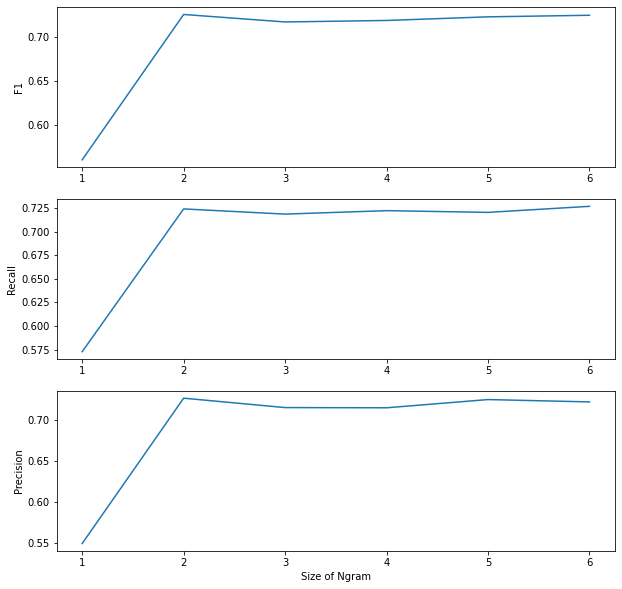

In [56]:
icut = 2
ocut = 2
smoothing = 'unsmoothed'

recall = []
precision = []
f1 = []
for order in range(1, 7):
    refs = read_corpus_conll(tst_conll)
    hyps = read_fst4conll(os.path.join(
        w2tmle_path, '(icut_{})_(ocut_{})_(n_{})_({}).w2t_mle.inv.out'.format(icut, ocut, order, smoothing)))
    results = evaluate(refs, hyps)

    recall.append(results['total']['r'])
    precision.append(results['total']['p'])
    f1.append(results['total']['f'])

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(range(1, 7), f1)
axs[1].plot(range(1, 7), recall)
axs[2].plot(range(1, 7), precision)
axs[2].set_xlabel('Size of Ngram')
axs[0].set_ylabel('F1')
axs[1].set_ylabel('Recall')
axs[2].set_ylabel('Precision')

df = pd.DataFrame([recall, precision, f1], columns=[
                  'N=1', 'N=2', 'N=3', 'N=4', 'N=5', 'N=6'], index=['Recall', 'Precision', 'F1'])
display(df)

Among the tested Ngram orders, the best F1 and Precision achieved by using an Ngram of order 2. However, the Recall is slightly better using N=6.
In the case of N=2, the F1 equals 72.51%, the Recall is 72.41%, and Precision is 72.61%. During the following tests the N will be fixed to 2.

#### Smoothing Method

Using the best Ngram order found, which is 2, we will try to find the best Ngram smoothing method. In following evaluation the input and output cutoff frequency will be fixed to 2.

In [57]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

[ -d $w2tmle_path ] && echo "$w2tmle_path already exists" || mkdir $w2tmle_path

icut=2
ocut=2
order=2

for smoothing in "absolute" "katz" "kneser_ney" "presmoothed" "unsmoothed" "witten_bell"
do
    cat "$sym_path/isyms_(mincut_$icut).txt" "$sym_path/osyms_(mincut_$ocut).t.txt" | cut -f 1 | sort | uniq > "$sym_path/msyms.m.lst.txt"

    ngramsymbols --OOV_symbol='<unk>' "$sym_path/msyms.m.lst.txt" "$sym_path/msyms.t.txt"

    # let's convert data to ngrams
    cat trn.conll | sed '/^$/d' | awk '{print $2,$1}' > "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.txt"

    # compile to far
    farcompilestrings \
        --symbols=$sym_path/msyms.t.txt \
        --keep_symbols \
        --unknown_symbol='<unk>' \
         "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.txt"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.far"

    # count bigrams
    ngramcount --order=2  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.far"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.cnt"
    # make a model
    ngrammake  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.cnt"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.lm"

    # print ngram probabilities as negative logs
    ngramprint \
        --symbols=$sym_path/msyms.t.txt\
        --negativelogs \
         "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.lm"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.probs"
done

w2t_mle already exists


In [58]:
sym_path = 'syms'
far_path = 'far'
ngram_path = 'ngram'
lm_path = 'lm'
w2tmle_path = 'w2t_mle'

icut = 2
ocut = 2
order = 2
for smoothing in ["absolute", "katz", "kneser_ney", "presmoothed", "unsmoothed", "witten_bell"]:
    make_w2t_mle(
        os.path.join(
            w2tmle_path,
            'trn_(icut_{})_(ocut_{})_(n_{})_({}).w2t.probs'.format(
                icut, ocut, order, smoothing)
        ),
        out=os.path.join(
            w2tmle_path,
            'trn_(icut_{})_(ocut_{})_(n_{})_({}).w2t_mle.txt'.format(
                icut, ocut, order, smoothing)
        )
    )

In [59]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

icut=2
ocut=2
order=2

for smoothing in "absolute" "katz" "kneser_ney" "presmoothed" "unsmoothed" "witten_bell"
do
    fstcompile \
        --isymbols="$sym_path/osyms_(mincut_$ocut).t.txt" \
        --osymbols="$sym_path/isyms_(mincut_$icut).txt" \
        --keep_isymbols \
        --keep_osymbols \
         "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.txt"  "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.bin"

    # we need to invert it to have words on input
    fstinvert  "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.bin" \
                "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin"

    # fstinfo "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin" | head -n 8
    
    wdir='wdir'
    mkdir -p $wdir
    farextract --filename_prefix="$wdir/" "$far_path/tst_(mincut_$icut).far"
    
    farr=($(ls $wdir))

    for f in ${farr[@]}
    do
        fstcompose  $wdir/$f \
                    "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin" | \
        fstcompose - "$lm_path/t_(mincut_$ocut)_(order_$order)_($smoothing).lm" | \
            fstshortestpath | fstrmepsilon | fsttopsort | fstprint --isymbols="$sym_path/isyms_(mincut_$icut).txt" 
    done > "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.out"

done

,witten_bell,absolute,katz,kneser_ney,presmoothed,unsmoothed
Recall,0.725940,0.725940,0.723190,0.724106,0.725023,0.724106
Precision,0.727273,0.727273,0.724518,0.726103,0.727022,0.726103
F1,0.726606,0.726606,0.723853,0.725103,0.726021,0.725103


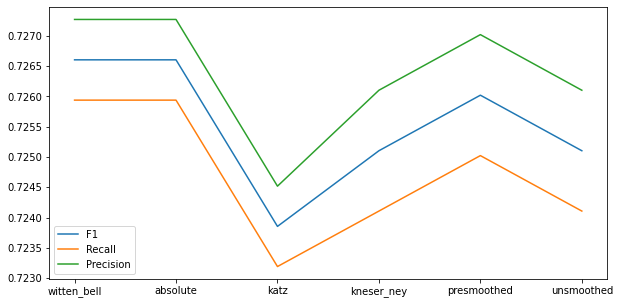

In [60]:
icut = 2
ocut = 2
order = 2

recall = []
precision = []
f1 = []

smoothing_methods = [ "witten_bell", "absolute", "katz", "kneser_ney", "presmoothed", "unsmoothed"]
for smoothing in smoothing_methods:
    refs = read_corpus_conll(tst_conll)
    hyps = read_fst4conll(os.path.join(
        w2tmle_path, '(icut_{})_(ocut_{})_(n_{})_({}).w2t_mle.inv.out'.format(icut, ocut, order, smoothing)))
    results = evaluate(refs, hyps)

    recall.append(results['total']['r'])
    precision.append(results['total']['p'])
    f1.append(results['total']['f'])

plt.figure(figsize=(10,5))
plt.plot(smoothing_methods, f1 , label='F1')
plt.plot(smoothing_methods, recall , label='Recall')
plt.plot(smoothing_methods, precision , label='Precision')
plt.legend()

df = pd.DataFrame([recall, precision, f1], columns=smoothing_methods, index=['Recall', 'Precision', 'F1'])
display(df)

Both `witten_bell` and `absolute` smoothing methods preform the same. With F1=72.66%, Recall=72.59%, and Precision=72.72%. Therefore, there is no difference between them in our point of view. The `witten_bell` will be used as the smoothing method from now on.

#### CutOff Frequencies

Now that we have fixed two parameters, Ngram Order and smoothing method, we can evaluate all combinations of cutoff frequencies for Tokens and Tags. We will assess the cutoff thresholds between 2 and 6.

In [61]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

[ -d $w2tmle_path ] && echo "$w2tmle_path already exists" || mkdir $w2tmle_path

order=2
smoothing="witten_bell"

for icut in {2..6}
do
    for ocut in {2..6}
    do
        cat "$sym_path/isyms_(mincut_$icut).txt" "$sym_path/osyms_(mincut_$ocut).t.txt" | cut -f 1 | sort | uniq > "$sym_path/msyms.m.lst.txt"

        ngramsymbols --OOV_symbol='<unk>' "$sym_path/msyms.m.lst.txt" "$sym_path/msyms.t.txt"

        # let's convert data to ngrams
        cat trn.conll | sed '/^$/d' | awk '{print $2,$1}' > "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.txt"

        # compile to far
        farcompilestrings \
            --symbols=$sym_path/msyms.t.txt \
            --keep_symbols \
            --unknown_symbol='<unk>' \
             "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.txt"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.far"

        # count bigrams
        ngramcount --order=2  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.far"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.cnt"
        # make a model
        ngrammake  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.cnt"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.lm"

        # print ngram probabilities as negative logs
        ngramprint \
            --symbols=$sym_path/msyms.t.txt\
            --negativelogs \
             "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.lm"  "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t.probs"
    done
done

w2t_mle already exists


In [62]:
sym_path = 'syms'
far_path = 'far'
ngram_path = 'ngram'
lm_path = 'lm'
w2tmle_path = 'w2t_mle'


order = 2
smoothing = "witten_bell"

for icut in range(2,7):
    for ocut in range(2,7):
        make_w2t_mle(
            os.path.join(
                w2tmle_path,
                'trn_(icut_{})_(ocut_{})_(n_{})_({}).w2t.probs'.format(
                    icut, ocut, order, smoothing)
            ),
            out=os.path.join(
                w2tmle_path,
                'trn_(icut_{})_(ocut_{})_(n_{})_({}).w2t_mle.txt'.format(
                    icut, ocut, order, smoothing)
            )
        )

In [63]:
%%bash
sym_path='syms'
far_path='far'
ngram_path='ngram'
lm_path='lm'
w2tmle_path='w2t_mle'

order=2
smoothing="witten_bell"

for icut in {2..6}
do
    for ocut in {2..6}
    do
        fstcompile \
            --isymbols="$sym_path/osyms_(mincut_$ocut).t.txt" \
            --osymbols="$sym_path/isyms_(mincut_$icut).txt" \
            --keep_isymbols \
            --keep_osymbols \
             "$w2tmle_path/trn_(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.txt"  "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.bin"

        # we need to invert it to have words on input
        fstinvert  "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.bin" \
                    "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin"

        # fstinfo "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin" | head -n 8

        wdir='wdir'
        mkdir -p $wdir
        farextract --filename_prefix="$wdir/" "$far_path/tst_(mincut_$icut).far"

        farr=($(ls $wdir))

        for f in ${farr[@]}
        do
            fstcompose  $wdir/$f \
                        "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.bin" | \
            fstcompose - "$lm_path/t_(mincut_$ocut)_(order_$order)_($smoothing).lm" | \
                fstshortestpath | fstrmepsilon | fsttopsort | fstprint --isymbols="$sym_path/isyms_(mincut_$icut).txt" 
        done > "$w2tmle_path/(icut_$icut)_(ocut_$ocut)_(n_$order)_($smoothing).w2t_mle.inv.out"

    done
done

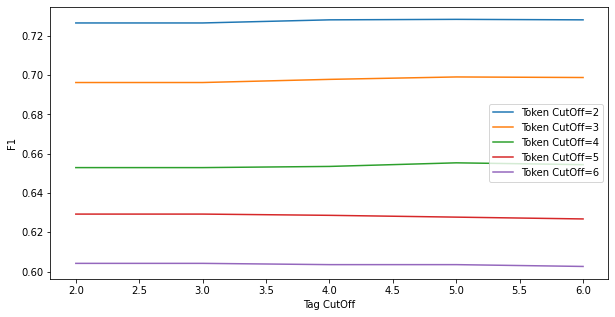

In [64]:
recall = []
precision = []
f1 = []

order = 2
smoothing = "witten_bell"

for icut in range(2, 7):
    recall.append([])
    precision.append([])
    f1.append([])
    for ocut in range(2, 7):
        refs = read_corpus_conll(tst_conll)
        hyps = read_fst4conll(os.path.join(
            w2tmle_path, '(icut_{})_(ocut_{})_(n_{})_({}).w2t_mle.inv.out'.format(icut, ocut, order, smoothing)))
        results = evaluate(refs, hyps)

        recall[icut-2].append(results['total']['r'])
        precision[icut-2].append(results['total']['p'])
        f1[icut-2].append(results['total']['f'])

plt.figure(figsize=(10, 5))
for icut in range(2, 7):
    plt.plot([2, 3, 4, 5, 6], f1[icut-2], label="Token CutOff={}".format(icut))
plt.legend()
plt.xlabel('Tag CutOff')
plt.ylabel('F1')
plt.show()

According to the above chart it is obvious that with Token Cutoff threshold equal to 2 we can achieve the best F1. Now for better comparison let's focus on Token Cutoff equal to 2.

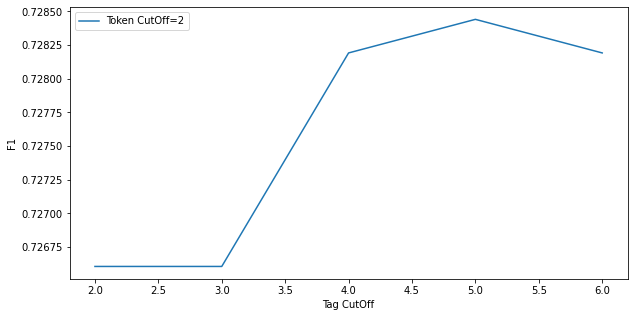

In [65]:
plt.figure(figsize=(10, 5))
plt.plot([2, 3, 4, 5, 6], f1[0], label="Token CutOff={}".format(2))
plt.legend()
plt.xlabel('Tag CutOff')
plt.ylabel('F1')
plt.show()

Now we can see that for Tag CutOff the best F1 occurs at 5.

In [66]:
df=pd.DataFrame([f1[0][3],recall[0][3],precision[0][3]],columns=["For Token_CutOff=2 and Tag_CutOff=5"],index=["F1","Recall","Precision"])
display(df)

,For Token_CutOff=2 and Tag_CutOff=5
F1,0.728440
Recall,0.727773
Precision,0.729109
